In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


import scipy.linalg as sl

### QR Iteration: Basic version

At the most basic level, the QR iteration (not to be confused with QR factorization/decomposition) performs the following iterations:
    
    
while not converged: 
+ $A_i = Q_iR_i$   (QR factorization)
+ $A_{i+1} = R_iQ_i$ (matrix matrix multiplication)
+ $i = i + 1$
        
This is performing a sequence of similarity transformations since 

$$ A_{i+1} = R_iQ_i = Q_i^* (Q_iR_i)Q_i = Q_i^* A_i Q_i. $$

Therefore, $A_{i+1}$ is unitarily similar to $A_i$ and therefore has the same eigenvalues. 

Therefore, after k iterations, we have 
$$ (Q_1\cdots Q_k)^* A (Q_1 \cdots Q_k). $$


Under some nice conditions (when all the eigenvalues are distinct), we can show that this iteration converges to the Schur form 
$$ U^* A U = T , $$

where $U$ is unitary and $T$ is upper triangular with the eigenvalues on the diagonal. When $A$ is Hermitian, this converges to a diagonal matrix. 


For this lecture, let us consider the symmetric case, which is much easier to study.


In [2]:
def qr_iter(A, maxiter = 100):
    
    
    n = A.shape[0]
    l = sl.eigvalsh(A)
    diags    =  np.zeros((n,maxiter), dtype = 'd')
    offdiags =  np.zeros((n-1, maxiter), dtype = 'd')
    
    Ak = np.copy(A)
    
    for k in range(maxiter):
        q, r = sl.qr(Ak)
        Ak = r @ q
        
        diags[:,k] = np.diag(Ak)
        offdiags[:,k] = np.diag(Ak,-1).flatten()
        
       
    f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))
    ax1.plot(diags.T)
    ax1.set_title('Diagonal', fontsize = 16)
    ax2.semilogy(np.abs(offdiags.T))
    ax2.set_title('Off-diagonals ', fontsize = 16)
        
    
    return Ak
        

### Visualizing the convergence of the QR iteration

The approximate eigenvalues are 
[0.64733465 1.93099328 2.48302899]
The eigenvalues computed using scipy are
[0.64733465 1.93099328 2.48302899]


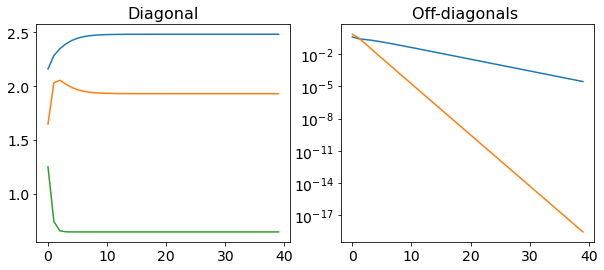

In [3]:
A = np.random.randn(3,3)
A = 0.5*(A+A.T)

D = qr_iter(A,40)

print('The approximate eigenvalues are ')
print(np.sort(np.diag(D)))

d,v = sl.eigh(A)
print('The eigenvalues computed using scipy are')
print(np.sort(d))

What are some issues with the QR iteration? 
+ The cost is high. 
+ Convergence is slow. Often takes many many iterations.
+ How do we detect convergence? 

 
Each step costs $\mathcal{O}(n^3)$. If it takes $\mathcal{O}(1)$ iterations per eigenvalue, then in the worst case the cost is $\mathcal{O}(n^4)$ flops.


For an efficient implementation, we need several "tricks". 
1. Reduce $A$ to tridiagonal form $T$ by a series of orthogonal transformations.
2. Use shifted QR iterations for faster convergence
3. Use perturbation theory to determine stopping criteria.



### Step 1: Tridiagonalization

Use a sequence of householder transformations. For example, for a $n\times n$ symmetric matrix, we need $n-2$ Householder matrices s.t., 

$$ T = H_{n-2} \cdots H_2 H_1 A H_1 H_2 \dots H_{n-2}. $$

As an illustration for the $4\times 4$ case, we have 
$$ \begin{bmatrix} x & x & x & x \\ x & x & x & x \\ x & x & x & x \\ x & x & x & x  \end{bmatrix} \stackrel{H_1}{\longrightarrow}  \begin{bmatrix} x & x & 0 & 0 \\ x & x & x & x \\ 0 & x & x & x \\ 0 & x & x & x  \end{bmatrix} 
\stackrel{H_2}{\longrightarrow}  \begin{bmatrix} x & x & 0 & 0 \\ x & x & x & 0 \\ 0 & x & x & x \\ 0 & 0 & x & x  \end{bmatrix} 
.$$

The cost of this operation is $ \frac{8}{3}n^3 + \mathcal{O}(n^2) $ flops if eigenvectors are desired. If only the eigenvalues are desired, the cost can be reduced by half.

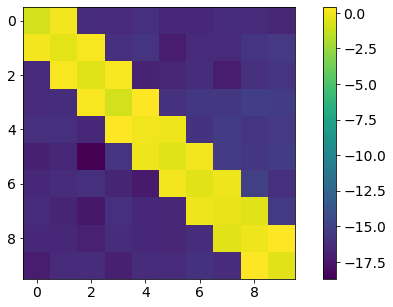

In [4]:
def householder(x):
    """
    Given a nonzero vector x, compute 
    
    H = I - 2uu^T
    
    where u = x +sign(x)e_1
    
    """
    
    n = x.size
    alpha = np.sign(x[0])
    
    
    
    e1 = np.zeros((n,), dtype = 'd')
    e1[0] = np.linalg.norm(x)
    v = x + alpha*e1
    
    u = v/np.linalg.norm(v)
    H = np.eye(n) - 2*np.outer(u,u)
    
    
    return u, H

def tridiagonalize(A):
    """
    
    Reduce to tridiagonal form using Householder reflections
    
    """
    
    n = A.shape[0]
    T = np.copy(A)
    
    for k in range(n-1):
        u, H = householder(T[k+1:,k])
        
        Q = sl.block_diag(np.eye(k+1),H)
        T = Q @ (T @ Q.T)
    
    return T
                        
    
#Example on a 10 x 10 matrix    
A = np.random.randn(10,10)
A = 0.5*(A+A.T)
T = tridiagonalize(A)
plt.imshow(np.log10(np.abs(T)))
plt.colorbar()

### Step 2: QR iteration with shifts

while not converged
 + pick a shift $\tau$
 + Compute $QR = T - \tau I$
 + Compute $ T_+ = RQ + \tau I $ 

    
At each iteration we require computing a QR factorization of a tridiagonal matrix. This can be done efficiently using Givens' rotations in $\mathcal{O}(n)$ flops.

How to pick the shift $\tau$? We need an approximation to an eigenvalue of $T$. Two options:
1. Use $\sigma = T_{nn}$ as an approximate eigenvalue
2. Wilkinson's shift: Use $\sigma$ as an eigenvalue of the $2 x 2$ matrix
$$ \begin{bmatrix} T_{n-1,n-1} & T_{n-1,n} \\ T_{n-1,n} & T_{nn} \end{bmatrix}. $$

Roughly speaking, the convergence with this shift is cubic. In practice, we only need 1-2 iterations per eigenvalue. Therefore, the cost is $\mathcal{O}(n^2)$ to get all the eigenvalues. To get the eigenvectors, we need to use a more sophisticated technique.


After a few iterations, the tridiagonal matrix will look like 
$$ T = \begin{bmatrix} \hat{T}_{11} \\ & \hat{T}_{22}\end{bmatrix} , $$
where $\hat{T}_{22}$ will be approximately a diagonal matrix with the converged eigenvalues on the diagonals, and $\hat{T}_{11}$ will be in tridiagonal form. We only need to work with $T_{11}$.


The code below implements this idea.

In [5]:
def qr_shift(A):
    
    T = tridiagonalize(A)
    
    n = T.shape[0]
    m = n-1
    
    eps = 10**(-8)
    
    iterc  = 0
    maxiter = 100
    
    diags    =  np.zeros((n,maxiter), dtype = 'd')
    offdiags =  np.zeros((n-1, maxiter), dtype = 'd')
    
    while m > 1 and iterc <= maxiter:
        #Pick the last 2 x 2 submatrix to find shift
        d = sl.eigvalsh(T[m-1:m+1,m-1:m+1])
        s = d[0]
        
        #One step of QR iteration with shifts
        I = np.eye(m+1)
        q, r = sl.qr(T[:m+1,:m+1]- s*I)
        T[:m+1,:m+1] = r @ q + s*I 
        
        iterc += 1
   
        diags[:,iterc] = np.diag(T)
        offdiags[:,iterc] = np.diag(T,-1).flatten()
        
        
        #Check if the off-diagonal is sufficiently small
        #Reduce size of tridiagonal matrix to work with
        if np.abs(T[m,m-1]) <= eps*(np.abs(T[m,m]) + np.abs(T[m-1,m-1])):
            m = m -1

            
    f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,4))
    ax1.plot(diags[:,:iterc].T)
    ax1.set_title('Diagonal', fontsize = 16)
    ax2.semilogy(np.abs(offdiags[:,:iterc].T))
    ax2.set_title('Off-diagonals ', fontsize = 16)          
    
    print('Number of iterations', iterc)
    return T 
                                    


Number of iterations 23

Approximate Eigenvalues are 
 [-3.80516738 -2.64841778 -2.03270727 -1.6582157  -1.0166992   0.79930666
  1.37466221  2.19479923  2.27976028  3.63213192]
Correct Eigenvalues are 
 [-3.80516738 -2.64841778 -2.03270727 -1.6582157  -1.0166992   0.79930666
  1.37466221  2.19479923  2.27976028  3.63213192]


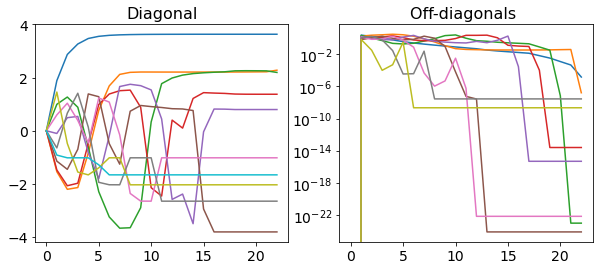

In [6]:
A = np.random.randn(10,10)
A = 0.5*(A+A.T)
D = qr_shift(A)
print()
print('Approximate Eigenvalues are \n', np.sort(np.diag(D)))
print('Correct Eigenvalues are \n', sl.eigvalsh(A))

### Overall cost:

1. Step 1: Tridiagonalization $\frac{8}{3}n^3 + \mathcal{O}(n^2)$. 
2. Step 2: QR iteration with shifts
    - Roughly $2$ iterations per eigenvalue, on average. $\mathcal{O}(n)$ per iteration
    - Total cost is $6n^3 + \mathcal{O}(n^2)$

Total cost = $\sim 9n^3 + \mathcal{O}(n^2). $ Cost can be reduced if only eigenvalues are desired. 


There are other algorithms for symmetric matrices besides QR iteration in the second step, e.g., divide-and-conquer.

### QR iteration for nonsymmetric matrices

Similar to symmetric matrices, QR iteration on nonsymmetric matrices proceed in two stages:
    
1. Stage 1: Convert A to upper-Hessenberg form through a sequence of Householder transforms
    $$ H = Z_{n-2}\cdots Z_1 A Z_{1}\cdots Z_{n-2} , $$
2. Stage 2: QR iteration with shifts 
    while not converged
         + pick a shift $\tau$
         + Compute $QR = H - \tau I$
         + Compute $ H_+ = RQ + \tau I $ 
        
        
However, since eigenvalues can be complex and occur in conjugate pairs, extra effort must be taken. 
- QR shift with shifts $\tau$ and $\bar{\tau}$
- Implicit Q theorem which makes the computations of the eigenvectors feasible.